In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys
import os

sys.path.append('../tools')
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
from torch import nn
from tqdm import tqdm
import sklearn

import torchvision.transforms as T
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks

import data_utility
import times
import segmentation
import preprocess
import autoencoder
import visualizer
import kaggle_data_utility
from kaggle_data_utility import KaggleDataset

In [3]:
data_dir = "../../../user_data/competition_data/clips"
log_folder_root = '../../../user_data/logs/'
ckpt_folder_root = '../../../user_data/checkpoints/'

targets = [
    'Dog_1',
    'Dog_2',
    'Dog_3',
    'Dog_4',
]

# targets = [
#     'Patient_1',
#     'Patient_2',
#     'Patient_3',
#     'Patient_4',
#     'Patient_5',
#     'Patient_6',
#     'Patient_7',
#     'Patient_8'
# ]

In [4]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
determine_generator = torch.Generator()
determine_generator.manual_seed(random_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    # True ensures the algorithm selected by CUFA is deterministic
    torch.backends.cudnn.deterministic = True
    # torch.set_deterministic(True)
    # False ensures CUDA select the same algorithm each time the application is run
    torch.backends.cudnn.benchmark = False

In [5]:
ictal_data_list = [kaggle_data_utility.parse_input_data(data_dir, targets[i], 'ictal', None) for i in
                   range(len(targets))]
interictal_data_list = [kaggle_data_utility.parse_input_data(data_dir, targets[i], 'interictal', None) for i in
                        range(len(targets))]
test_data_list = [kaggle_data_utility.parse_input_data(data_dir, targets[i], 'test', None) for i in range(len(targets))]

Loading data
(0s)
X (178, 16, 400) y (178,) latencies (178,)
Loading data
(0s)
X (172, 16, 400) y (172,) latencies (172,)
Loading data
(0s)
X (480, 16, 400) y (480,) latencies (480,)
Loading data
(0s)
X (257, 16, 400) y (257,) latencies (257,)
Loading data
(0s)
X (418, 16, 400) y (418,)
Loading data
(0s)
X (1148, 16, 400) y (1148,)
Loading data
(2s)
X (4760, 16, 400) y (4760,)
Loading data
(1s)
X (2790, 16, 400) y (2790,)
Loading data
(1s)
X (3181, 16, 400)
Loading data
(1s)
X (2997, 16, 400)
Loading data
(2s)
X (4450, 16, 400)
Loading data
(1s)
X (3013, 16, 400)


In [6]:
ictal_data_X = np.empty((0, 16, 400))
interictal_data_X = np.empty((0, 16, 400))
test_data_X = np.empty((0, 16, 400))
for data in ictal_data_list:
    ictal_data_X = np.vstack((ictal_data_X, data['X']))
for data in interictal_data_list:
    interictal_data_X = np.vstack((interictal_data_X, data['X']))
for data in test_data_list:
    test_data_X = np.vstack((test_data_X, data['X']))

In [7]:
unlabeled_dataset = KaggleDataset(ictal_data_X, interictal_data_X, test_data_X, labeled=False, transform=True,astensor = False)
train_set_size = int(unlabeled_dataset.length * 0.8)
valid_set_size = unlabeled_dataset.length - train_set_size
train_set, test_set = torch.utils.data.random_split(unlabeled_dataset, [train_set_size, valid_set_size],generator=determine_generator)

In [8]:
unlabeled_dataset.length

23844

In [9]:
# import torch
# import torchvision
# from torch import nn
#
# from lightly.data import LightlyDataset, SwaVCollateFunction
# from lightly.loss import SwaVLoss
# from lightly.loss.memory_bank import MemoryBankModule
# from lightly.models.modules import SwaVProjectionHead, SwaVPrototypes
#
#
# class SwaV(nn.Module):
#     def __init__(self, backbone):
#         super().__init__()
#         self.backbone = backbone
#         self.projection_head = SwaVProjectionHead(512, 512, 128)
#         self.prototypes = SwaVPrototypes(128, 512, 5)
#
#         self.start_queue_at_epoch = 30
#         self.queues = nn.ModuleList([MemoryBankModule(size=512) for _ in range(2)])
#
#     def forward(self, high_resolution, low_resolution, epoch):
#         self.prototypes.normalize()
#
#         high_resolution_features = [self._subforward(x) for x in high_resolution]
#         low_resolution_features = [self._subforward(x) for x in low_resolution]
#
#         high_resolution_prototypes = [
#             self.prototypes(x, epoch) for x in high_resolution_features
#         ]
#         low_resolution_prototypes = [
#             self.prototypes(x, epoch) for x in low_resolution_features
#         ]
#         queue_prototypes = self._get_queue_prototypes(high_resolution_features, epoch)
#
#         return high_resolution_prototypes, low_resolution_prototypes, queue_prototypes
#
#     def _subforward(self, input):
#         features = self.backbone(input).flatten(start_dim=1)
#         features = self.projection_head(features)
#         features = nn.functional.normalize(features, dim=1, p=2)
#         return features
#
#     @torch.no_grad()
#     def _get_queue_prototypes(self, high_resolution_features, epoch):
#         if len(high_resolution_features) != len(self.queues):
#             raise ValueError(
#                 f"The number of queues ({len(self.queues)}) should be equal to the number of high "
#                 f"resolution inputs ({len(high_resolution_features)}). Set `n_queues` accordingly."
#             )
#
#         # Get the queue features
#         queue_features = []
#         for i in range(len(self.queues)):
#             _, features = self.queues[i](high_resolution_features[i], update=True)
#             # Queue features are in (num_ftrs X queue_length) shape, while the high res
#             # features are in (batch_size X num_ftrs). Swap the axes for interoperability.
#             features = torch.permute(features, (1, 0))
#             queue_features.append(features)
#
#         # If loss calculation with queue prototypes starts at a later epoch,
#         # just queue the features and return None instead of queue prototypes.
#         if self.start_queue_at_epoch > 0 and epoch < self.start_queue_at_epoch:
#             return None
#
#         # Assign prototypes
#         queue_prototypes = [self.prototypes(x, epoch) for x in queue_features]
#         return queue_prototypes
#
#
# resnet = torchvision.models.resnet34()
#
# backbone = nn.Sequential(*list(resnet.children())[:-1])
# model = SwaV(backbone)
#
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

# collate_fn = SwaVCollateFunction(gaussian_blur = 0, hf_prob = 0,vf_prob = 0,rr_prob=0,cj_prob=0,random_gray_scale=0, normalize={'mean':[0, 0, 0], 'std':[1, 1, 1]})
#
# dataloader = torch.utils.data.DataLoader(
#     unlabeled_dataset,
#     batch_size=128,
#     collate_fn=collate_fn,
#     shuffle=True,
#     drop_last=True,
# )
#
# criterion = SwaVLoss(sinkhorn_epsilon = 0.05)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#
# # torch.save({
# #             'epoch': -1,
# #             'model_state_dict': model.state_dict(),
# #             'optimizer_state_dict': optimizer.state_dict(),
# #             'loss': -1,
# #             }, 'ckpt/checkpoint_round_2'+str(-1)+'.pth')
#
# print("Starting Training")
# for epoch in range(100):
#     total_loss = 0
#     i = 0
#     for batch, _, _ in tqdm(dataloader):
#         batch = [x.to(device) for x in batch]
#         high_resolution, low_resolution = batch[:2], batch[2:]
#         high_resolution, low_resolution, queue = model(
#             high_resolution, low_resolution, epoch
#         )
#         loss = criterion(high_resolution, low_resolution, queue)
#         total_loss += loss.detach()
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#
#     avg_loss = total_loss / len(dataloader)
#     torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': avg_loss,
#             }, 'kaggle_human_ckpt/checkpoint'+str(epoch)+'.pth')
#
#     print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

In [10]:
from models.SwaV import SwaV
from models.SupervisedDownstream import SupervisedDownstream
from lightly.data import SwaVCollateFunction
#
model = SwaV()

# model.load_from_checkpoint()

collate_fn = SwaVCollateFunction(gaussian_blur = 0, hf_prob = 0,vf_prob = 0,rr_prob=0,cj_prob=0,random_gray_scale=0, normalize={'mean':[0, 0, 0], 'std':[1, 1, 1]})

dataloader = torch.utils.data.DataLoader(
    unlabeled_dataset,
    batch_size=64,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)
accelerator = "gpu" if torch.cuda.is_available() else "cpu"

checkpoint_callback = pl_callbacks.ModelCheckpoint(monitor='swav_loss',filename='kaggle_dog_swav-{epoch:02d}-{swav_loss:.5f}', save_last=True, save_top_k=-1, dirpath=ckpt_folder_root + 'kaggle_dog_swav_50')
csv_logger = pl_loggers.CSVLogger(log_folder_root, name="kaggle_dog_swav")

trainer = pl.Trainer(logger=csv_logger, max_epochs=120, callbacks=[checkpoint_callback],accelerator='gpu', devices=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model=model, train_dataloaders=dataloader)


C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:616: UserWarning: Checkpoint directory C:\Users\Patrick Xu\Desktop\RNS_Annotation-Pipeline\user_data\checkpoints\kaggle_dog_swav_50 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type               | Params
-------------------------------------------------------
0 | backbone        | Sequential         | 23.5 M
1 | projection_head | SwaVProjectionHead | 4.5 M 
2 | prototypes      | SwaVPrototypes     | 66.0 K
3 | queues          | ModuleList         | 0     
4 | criterion       | SwaVLoss           | 0     
-------------------------------------------------------
28.0 M    Trainable params
0         Non-trainable params
28.0 M    Total params
112.139   Total estimated model params size (MB)
C:\Users\Patrick Xu\AppData\Local\Programs\Python\Pytho

Training: 0it [00:00, ?it/s]

In [12]:
# unlabeled_dataset = KaggleDataset(ictal_data_X, interictal_data_X, test_data_X, labeled=False, transform=True)
# train_set_size = int(labeled_dataset.length * 0.8)
# valid_set_size = labeled_dataset.length - train_set_size
# train_set, test_set = torch.utils.data.random_split(labeled_dataset, [train_set_size, valid_set_size])

In [13]:
# swav = SwaV().load_from_checkpoint(ckpt_folder_root + 'kaggle_dog_swav_18/kaggle_dog_swav-epoch=116-swav_loss=2.23095.ckpt')
# swav = SwaV().load_from_checkpoint(ckpt_folder_root + 'kaggle_dog_swav_34/kaggle_dog_swav-epoch=116-swav_loss=2.73583.ckpt')
swav = SwaV().load_from_checkpoint(ckpt_folder_root + 'kaggle_dog_swav_50/kaggle_dog_swav-epoch=118-swav_loss=3.64062.ckpt')
model = SupervisedDownstream(swav.backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

checkpoint_callback = pl_callbacks.ModelCheckpoint(monitor='val_loss',filename='kaggle_dog_linear_eval-{epoch:02d}-{val_loss:.5f}', save_last=True, save_top_k=-1, dirpath=ckpt_folder_root + 'kaggle_dog_swav_50_linear_eval')
csv_logger = pl_loggers.CSVLogger(log_folder_root, name="kaggle_dog_swav_50_linear_eval")

trainer = pl.Trainer( logger=csv_logger, max_epochs=80, callbacks=[checkpoint_callback],accelerator='gpu', devices=1)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:

labeled_dataset = KaggleDataset(ictal_data_X, interictal_data_X, test_data_X, labeled=True, transform=True)
train_set_size = int(labeled_dataset.length * 0.8)
valid_set_size = labeled_dataset.length - train_set_size
train_set, test_set = torch.utils.data.random_split(labeled_dataset, [train_set_size, valid_set_size],generator=torch.Generator().manual_seed(42))

def collate_fn(batch):
    info = list(zip(*batch))
    data = info[0]
    label = info[1]
    return torch.stack(data), torch.stack(label)

train_dataloader = torch.utils.data.DataLoader(
    train_set,
    batch_size=64,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)
val_dataloader = torch.utils.data.DataLoader(
    test_set,
    batch_size=64,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True,
)
trainer.fit(model, train_dataloader, val_dataloader)

C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:616: UserWarning: Checkpoint directory C:\Users\Patrick Xu\Desktop\RNS_Annotation-Pipeline\user_data\checkpoints\kaggle_dog_swav_50_linear_eval exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | backbone | Sequential | 23.5 M
1 | fc1      | Linear     | 524 K 
2 | fc2      | Linear     | 16.4 K
3 | fc3      | Linear     | 520   
4 | fc4      | Linear     | 18    
5 | softmax  | Softmax    | 0     
----------------------------------------
24.0 M    Trainable params
0         Non-trainable params
24.0 M    Total params
96.198    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: 0it [00:00, ?it/s]

C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: 0it [00:00, ?it/s]

C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Validation: 0it [00:00, ?it/s]

C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [17]:
labeled_dataset = KaggleDataset(ictal_data_X, interictal_data_X, test_data_X, labeled=True, transform=False)
train_set_size = int(labeled_dataset.length * 0.8)
valid_set_size = labeled_dataset.length - train_set_size
train_set, test_set = torch.utils.data.random_split(labeled_dataset, [train_set_size, valid_set_size],generator=torch.Generator().manual_seed(42))
train_dataloader = torch.utils.data.DataLoader(
    train_set,
    batch_size=128,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)
val_dataloader = torch.utils.data.DataLoader(
    test_set,
    batch_size=128,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True,
)
predictions = trainer.predict(model,val_dataloader,ckpt_path='checkpoints/swav_pretrained_unfreeze-epoch=71-val_loss=0.00116.ckpt')

Restoring states from the checkpoint path at checkpoints/swav_pretrained_unfreeze-epoch=71-val_loss=0.00116.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at checkpoints/swav_pretrained_unfreeze-epoch=71-val_loss=0.00116.ckpt
C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [ ]:
train_set

In [18]:
output_list = []
target_list = []
m = nn.Softmax(dim=1)
for pred, y,_ in predictions:
    out = m(pred)
    print(out)
    output_list.append(out)
    target_list.append(y)

tensor([[9.9856e-01, 1.4381e-03],
        [1.0000e+00, 1.4719e-08],
        [9.8982e-01, 1.0181e-02],
        [1.0000e+00, 3.8623e-09],
        [1.0000e+00, 1.4017e-09],
        [9.9992e-01, 7.6297e-05],
        [9.8459e-01, 1.5410e-02],
        [9.9968e-01, 3.1978e-04],
        [1.0000e+00, 8.4013e-09],
        [9.9964e-01, 3.5815e-04],
        [1.0000e+00, 3.3500e-06],
        [1.0000e+00, 1.8931e-06],
        [1.2234e-01, 8.7766e-01],
        [1.0000e+00, 4.4658e-11],
        [9.9983e-01, 1.6728e-04],
        [1.0000e+00, 1.8793e-06],
        [9.9974e-01, 2.5970e-04],
        [1.0000e+00, 1.5844e-07],
        [9.9858e-01, 1.4152e-03],
        [1.0000e+00, 5.5978e-08],
        [7.7688e-04, 9.9922e-01],
        [1.0000e+00, 5.8742e-07],
        [1.0000e+00, 2.9709e-10],
        [1.0000e+00, 1.4818e-08],
        [1.9035e-01, 8.0965e-01],
        [1.0000e+00, 1.9459e-07],
        [9.9998e-01, 1.6534e-05],
        [7.2181e-01, 2.7819e-01],
        [3.5983e-03, 9.9640e-01],
        [9.999

In [19]:
output = torch.vstack(output_list)
target = torch.vstack(target_list)
inds = np.where(target==1)[0]

fpr, tpr, thresholds = sklearn.metrics.roc_curve(target,output[:,1],pos_label=1)
sklearn.metrics.auc(fpr, tpr)

0.9908258601928633

In [20]:
output[:,1][inds]

tensor([8.7766e-01, 9.9922e-01, 8.0965e-01, 9.9640e-01, 9.8466e-01, 9.7844e-01,
        9.9968e-01, 1.0000e+00, 9.9399e-01, 9.8691e-01, 9.9722e-01, 9.9965e-01,
        9.9999e-01, 9.6794e-01, 9.9998e-01, 7.5038e-01, 9.7969e-01, 4.3224e-01,
        9.9993e-01, 9.9973e-01, 9.9999e-01, 9.9993e-01, 9.9759e-01, 9.9943e-01,
        9.6917e-01, 9.9469e-01, 9.9733e-01, 9.9991e-01, 9.9995e-01, 9.9996e-01,
        9.9992e-01, 9.9934e-01, 9.9537e-01, 9.3444e-01, 9.9962e-01, 9.9999e-01,
        9.9995e-01, 2.3389e-02, 9.9998e-01, 9.9990e-01, 9.8711e-01, 9.9136e-01,
        9.9663e-01, 9.7304e-01, 9.9541e-01, 9.8893e-01, 9.9986e-01, 9.7436e-01,
        3.3782e-06, 9.9770e-01, 9.9962e-01, 9.9999e-01, 9.9991e-01, 9.9995e-01,
        9.9998e-01, 9.9997e-01, 8.0182e-01, 9.9991e-01, 2.8445e-03, 9.9994e-01,
        9.9991e-01, 9.9686e-01, 9.9503e-01, 9.9982e-01, 9.9461e-01, 8.5797e-07,
        9.9999e-01, 9.9998e-01, 3.3104e-01, 9.9998e-01, 9.7686e-01, 9.9202e-01,
        9.9998e-01, 1.1320e-03, 9.9991e-

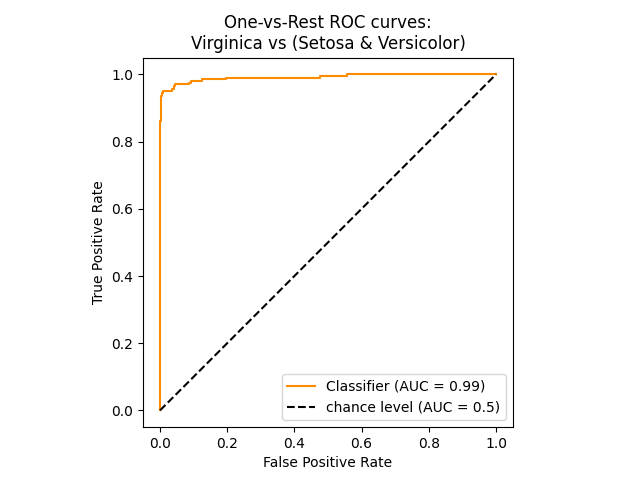

In [21]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(
    target,
    output[:,1],
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

In [23]:
output[:,1]

tensor([1.4381e-03, 1.4719e-08, 1.0181e-02,  ..., 3.8105e-06, 4.2247e-08,
        6.0167e-08])

In [24]:

output = torch.argmax(output, dim=1)
output = output.detach().cpu().numpy()
target= target.squeeze().detach().cpu().numpy()

In [25]:
import sklearn

clf_report = sklearn.metrics.classification_report(output, target, digits=6)

print(f"Classification Report : \n{clf_report}")

Classification Report : 
              precision    recall  f1-score   support

           0   0.996736  0.992416  0.994571      1846
           1   0.931034  0.969231  0.949749       195

    accuracy                       0.990201      2041
   macro avg   0.963885  0.980823  0.972160      2041
weighted avg   0.990458  0.990201  0.990289      2041



In [ ]:
for batch, label in tqdm(val_dataloader):
        batch = batch.to(device)
        label = label.to(device)
        label = F.one_hot(label).squeeze()
        outputs = model(batch)
        print(batch)
        loss = sigmoid_focal_loss(pred.float(),label.float(), alpha = 0.5, gamma = 8,reduction = 'mean')
        print(loss)
        break

In [ ]:
# import copy
# import torch
# import torchvision
# from torch import nn
#
# from lightly.data import DINOCollateFunction, LightlyDataset
# from lightly.loss import DINOLoss
# from lightly.models.modules import DINOProjectionHead
# from lightly.models.utils import deactivate_requires_grad, update_momentum
# from lightly.utils.scheduler import cosine_schedule
#
#
# class DINO(torch.nn.Module):
#     def __init__(self, backbone, input_dim):
#         super().__init__()
#         self.student_backbone = backbone
#         self.student_head = DINOProjectionHead(
#             input_dim, 512, 64, 2048, freeze_last_layer=1
#         )
#         self.teacher_backbone = copy.deepcopy(backbone)
#         self.teacher_head = DINOProjectionHead(input_dim, 512, 64, 2048)
#         deactivate_requires_grad(self.teacher_backbone)
#         deactivate_requires_grad(self.teacher_head)
#
#     def forward(self, x):
#         y = self.student_backbone(x).flatten(start_dim=1)
#         z = self.student_head(y)
#         return z
#
#     def forward_teacher(self, x):
#         y = self.teacher_backbone(x).flatten(start_dim=1)
#         z = self.teacher_head(y)
#         return z
#
#
# resnet = torchvision.models.resnet18()
# backbone = nn.Sequential(*list(resnet.children())[:-1])
# input_dim = 512
# # instead of a resnet you can also use a vision transformer backbone as in the
# # original paper (you might have to reduce the batch size in this case):
# # backbone = torch.hub.load('facebookresearch/dino:main', 'dino_vits16', pretrained=False)
# # input_dim = backbone.embed_dim
#
# model = DINO(backbone, input_dim)
#
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)
#
# # # we ignore object detection annotations by setting target_transform to return 0
# # pascal_voc = torchvision.datasets.VOCDetection(
# #     "datasets/pascal_voc", download=True, target_transform=lambda t: 0
# # )
# # dataset = LightlyDataset.from_torch_dataset(pascal_voc)
# # # or create a dataset from a folder containing images or videos:
# # # dataset = LightlyDataset("path/to/folder")
#
# collate_fn = DINOCollateFunction(solarization_prob = 0, hf_prob = 0,vf_prob = 0,rr_prob=0,cj_prob=0,random_gray_scale=0)
#
# dataloader = torch.utils.data.DataLoader(
#     train_set,
#     batch_size=64,
#     collate_fn=collate_fn,
#     shuffle=True,
#     drop_last=True,
#     num_workers=1,
# )
#
# criterion = DINOLoss(
#     output_dim=2048,
#     warmup_teacher_temp_epochs=5,
# )
# # move loss to correct device because it also contains parameters
# criterion = criterion.to(device)
#
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#
# epochs = 10
#
# print("Starting Training")
# for epoch in range(epochs):
#     total_loss = 0
#     momentum_val = cosine_schedule(epoch, epochs, 0.996, 1)
#     for views, _, _ in tqdm(dataloader):
#         update_momentum(model.student_backbone, model.teacher_backbone, m=momentum_val)
#         update_momentum(model.student_head, model.teacher_head, m=momentum_val)
#         views = [view.to(device) for view in views]
#         global_views = views[:2]
#         teacher_out = [model.forward_teacher(view) for view in global_views]
#         student_out = [model.forward(view) for view in views]
#         loss = criterion(teacher_out, student_out, epoch=epoch)
#         total_loss += loss.detach()
#         loss.backward()
#         # We only cancel gradients of student head.
#         model.student_head.cancel_last_layer_gradients(current_epoch=epoch)
#         optimizer.step()
#         optimizer.zero_grad()
#
#     avg_loss = total_loss / len(dataloader)
#     print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

In [ ]:
augmentation = T.Compose([
    T.ToPILImage(),
    T.Resize((256, 512), interpolation=T.InterpolationMode.NEAREST),
    T.RandomApply([T.ColorJitter()], p=0.5),
    T.RandomApply([T.GaussianBlur(kernel_size=(3, 3))], p=0.5),
    T.RandomInvert(p=0.2),
    T.RandomPosterize(4, p=0.2),
])

data = ictal_data_X[0]

channel_index = np.arange(data.shape[0])
np.random.shuffle(channel_index)
data = data[channel_index]
data = torch.from_numpy(data).clone()
data = data.repeat(3, 1, 1)
data = augmentation(data)
data

In [ ]:
channel_index

In [ ]:
data[channel_index]

In [ ]:
data

In [ ]:
#
# print("Starting Training")
# for epoch in range(50):
#     total_loss = 0
#     i = 0
#     for batch, label in tqdm(dataloader):
#         batch = batch.to(device)
#         # print(type(batch))
#         label = label.to(device)
#         label = F.one_hot(label).squeeze()
#         outputs = model(batch)
#         loss = sigmoid_focal_loss(outputs.float(),label.float(), alpha = 0.25, gamma = 7,reduction = 'mean')
#         total_loss += loss.detach()
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#
#     avg_loss = total_loss / len(dataloader)
#     torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': avg_loss,
#             }, 'ckpt/checkpoint'+str(epoch)+'.pth')
#
#     print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")    